In [1]:
import pickle
import copy
import torch
import time
import numpy as np
np.set_printoptions(precision = 4)

import sys
sys.path.append('./../')

from datasets.dataset import _load_collection_real,_load_collection_syn,_load_collection_bbq_data
from models_utility.construct_models import _initialize_SMkernel_hyp,_initialize_SMkernel_hyp_v2,_make_gpmodel
from models_utility.param_gp import Param



from kernels.RBF_kernel import RBF
from kernels.SM_kernel import SM
from scipy.linalg import norm as fnorm


from utility.eval_metric import _evaluate_metric
import matplotlib.pyplot as plt



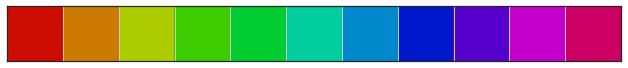

In [2]:
import seaborn as sns
sns.set()
sns.set_style('white')



plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(10+1, l=.4, s=1.0))
sns.palplot(current_palette)
current_palette = np.asarray(current_palette)

In [3]:
random_seed = 1000
device = True


#filename = 'SM_Q3_exp1_unequal_v3'
filename = 'SM_Q5_exp1_unequal_v3'
#SM_Q5_exp1_unequal_v3

#filename = 'SM_Q10_exp1_unequal_v3'
x_train, x_test, x_full, y_train, y_test,y_full,Dataset = _load_collection_syn(filename, cuda_option=device)


#filename = 'buzz'
#filename = 'pumadyn8nh'
#x_train, x_test, y_train, y_test = _load_collection_ssdkl_data(filename, random_seed=random_seed, numtotal=200000, cuda_option=device)


#loaded collection#
/home/yohan/Myenv/Summit_Conference/ICML21_SMapproximation/test


In [4]:
setting_dict = {}
setting_dict['random_seed'] = random_seed
setting_dict['init_sample_num'] = 100

#setting_dict['input_dim'] = x_train.shape[1]
setting_dict['input_dim'] = 1

setting_dict['Num_Q'] = 10
setting_dict['num_sample_pt'] = 5
setting_dict['num_batch'] = 1


setting_dict['lr_hyp'] = 1e-3         #0.001,0.0005  error -- >0.0001 equal_reg

setting_dict['kl_option'] = True   #['True','False']
setting_dict['num_batch'] = 1
setting_dict['tau0'] = 1000
setting_dict['iter'] = 4000        #[5000,8000]
setting_dict['num_rep'] = 1
setting_dict['weight_rate'] = 1e-3  # [1e-2,1e-3,1e-5]
setting_dict['optimizer'] = 'Adam'   #['SGD','Adam']
setting_dict['lr_hyp'] = 1e-3





setting_dict = _initialize_SMkernel_hyp_v2( x_train,y_train, setting_dict, random_seed)


In [5]:
setting_dict['hypparam']['weight']
hypparam_dict = setting_dict['hypparam']
mu = Param(torch.tensor(hypparam_dict['mean'] ), requires_grad=True, requires_transform=True, param_name='spt_mu')     # D x Q   transpose needed for our initialization Q x D 
std = Param(torch.tensor(hypparam_dict['std']), requires_grad=True,requires_transform=True, param_name='spt_std') # D x Q   transpose needed for our initialization Q x D 

mu_prior = Param(torch.tensor(hypparam_dict['mean_prior'] ), requires_grad=True, requires_transform=True, param_name='spt_mu')     # D x Q   transpose needed for our initialization Q x D 
std_prior = Param(torch.tensor(hypparam_dict['std_prior']), requires_grad=True,requires_transform=True, param_name='spt_std') # D x Q   transpose needed for our initialization Q x D 
#std_prior = Param(torch.tensor(np.ones_like(hypparam_dict['std_prior'])), requires_grad=True,requires_transform=True, param_name='spt_std') # D x Q   transpose needed for our initialization Q x D 

In [6]:
std_prior.transform()

tensor([[0.0207],
        [0.0742],
        [0.0392],
        [0.0182],
        [0.0744],
        [0.0070],
        [0.0885],
        [0.0953],
        [0.0931],
        [0.0415]], grad_fn=<ExpBackward>)

In [7]:
from torch.distributions import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal as MVN

def _kl_div_qp(mu,std,mu_prior,std_prior):
    q_dist = MVN(loc = mu.transform().view(1, -1).squeeze() ,
                 covariance_matrix = std.transform().view(1,-1).squeeze().pow(2).diag() )

    p_dist = MVN(loc = mu_prior.transform().view(1, -1).squeeze(),
                 covariance_matrix = std_prior.transform().view(1,-1).squeeze().pow(2).diag() )

    return kl_divergence(q_dist, p_dist)


def kl_gaussian(var_mu,var_std):
    return 0.5*((var_std).transform()**2 + (var_mu.transform()**2) - (2*var_std)  - 1.0).sum()

In [8]:
# _kl_div_qp(mu,std,mu_prior,std_prior),
# kl_gaussian(mu,std)


In [9]:
setting_dict['noise_err'] = .1 * y_train.cpu().data.numpy().std()

In [10]:
setting_dict.keys()

dict_keys(['random_seed', 'init_sample_num', 'input_dim', 'Num_Q', 'num_sample_pt', 'num_batch', 'lr_hyp', 'kl_option', 'tau0', 'iter', 'num_rep', 'weight_rate', 'optimizer', 'hypparam', 'noise_err'])

In [11]:
# Q = setting_dict['Num_Q']
# D = setting_dict['input_dim']
# K = setting_dict['num_sample_pt']


In [12]:
# import torch.nn as nn
# from models_utility.param_gp import Param
# from models_utility.function_gp import trtrs, cholesky, lt_log_determinant


# import math
# pi = math.pi



# # mu,Sigma for spectral points 
# # m,ls for p(a) 
# # D denote dimension of Y in vssgp code
# class VSSGP(nn.Module):
#     #def __init__(self,weight,mu,std,var_mu,var_std,a,b):
#     def __init__(self,train_X,train_Y,setting_dict,device):
        
#         # N, D
#         # Q : The number of component SM
#         # K : The number of spectral poinst for each component
#         # M=QK : The total number of spectral points for each componet
        
#         super(VSSGP,self).__init__()
        
        
        
#         self.device = torch.device("cuda") if device else torch.device('cpu')
#         self.name = 'VSSGP'                    
#         self.Q = setting_dict['Num_Q']
#         self.D = setting_dict['input_dim']
#         self.D_Y = 1 # IF multiouput, then D_Y > 1  
#         self.K = setting_dict['num_sample_pt']
#         self.total_sample_pt = self.Q*self.K

#         self.set_data(X= train_X,Y=train_Y)
        
        
#         #hyperparameter
#         hypparam_dict = setting_dict['hypparam']
#         self.weight = Param(torch.tensor(hypparam_dict['weight'].transpose()[0]).to(self.device) , requires_grad=True, requires_transform=True , param_name='weight')
#         self.mu = Param(torch.tensor(hypparam_dict['mean'].transpose() ).to(self.device), requires_grad=True, requires_transform=True, param_name='spt_mu')     # D x Q   transpose needed for our initialization Q x D 
#         self.std = Param(torch.tensor(hypparam_dict['std'].transpose()).to(self.device), requires_grad=True,requires_transform=True, param_name='spt_std') # D x Q   transpose needed for our initialization Q x D 
        
#         alpha,alpha_delta = (pi*torch.rand(self.K,self.Q)),(pi*torch.rand(self.K,self.Q))
#         alpha = alpha%(2*pi)
#         beta = (alpha + alpha_delta)%(2*pi)
#         self.alpha = Param(alpha.to(self.device),requires_grad=True,requires_transform=True, param_name='beta')             #cos(2pi s^T x + b_k)  b_k ~ \alpha,\beta
#         self.beta = Param(beta.to(self.device),requires_grad=True,requires_transform=True, param_name='beta')          #cos(2pi s^T x + b_k)  b_k ~ \alpha,\beta

        
#         #variational parameter for p(W)
#         var_mu = 10*torch.randn(self.D, self.K, self.Q)
#         var_sigma = 0.1*torch.rand( self.D, self.K, self.Q) 
#         self.var_mu_w =  Param( var_mu.to(self.device), requires_grad=True ,requires_transform=False, param_name='var_mu_for_alpha' )         #  (K x Q)  x D_Y 
#         self.var_sigma_w =  Param( var_sigma.to(self.device), requires_grad=True ,requires_transform=True, param_name='var_std_for_alpha' )       #  (K x Q) x D_Y
        
#         #variational parameter for p(A)        
#         mu0 = torch.randn( (self.K*self.Q), self.D_Y )
#         sigma0 = .1*torch.rand( (self.K*self.Q) , self.D_Y)
#         self.var_mu_a =  Param( mu0.to(self.device), requires_grad=True ,requires_transform=False, param_name='prior_mu' )         #  D x K x Q   
#         self.var_sigma_a =  Param( sigma0.to(self.device), requires_grad=True ,requires_transform=True, param_name='prior_std' )       #  D x K x Q 
        
        
#         a = .1*torch.randn(self.D,1)
#         self.a = Param( torch.tensor(a).to(self.device), requires_grad=True ,requires_transform=False, param_name='meanfun_slope' )   #slope
#         self.b = Param( torch.tensor(0).to(self.device), requires_grad=True ,requires_transform=False, param_name='meanfun_intercept' ) #intersept
        
#         tau = 1/(setting_dict['noise_err']**2)
#         self.tau = Param( torch.tensor(tau).to(self.device), requires_grad=True ,requires_transform=False, param_name='tau' )   #slope

        
#         self.lr_hyp = setting_dict['lr_hyp']        
#         self.optimizer = torch.optim.Adam(self.parameters(),
#                           lr=self.lr_hyp,
#                           betas=(0.9, 0.999),
#                           eps=1e-08,
#                           weight_decay=0.0)


        
#     def set_data(self,X,Y):
#         if torch.is_tensor(X):
#             self.X = X  # N x D
#             self.Y = Y  # N x 1
#         else:
#             self.X = torch.from_numpy(X).to(self.device)
#             self.Y = torch.from_numpy(X).to(self.device)

#         #z = torch.rand(self.D,self.K,self.Q)*(5*pi)
#         #self.z = Param(.to(self.device), requires_grad=True ,requires_transform=False, param_name='inducing_spectral_pt' )    #inducing points z_k    D x K x Q  

# #         z = torch.rand(self.D,self.K,self.Q)*(5*pi)
# #         self.z = Param(.to(self.device), requires_grad=True ,requires_transform=False, param_name='inducing_spectral_pt' )    #inducing points z_k    D x K x Q        

#         z = X[0].t()[:,None,None] + torch.randn(self.D,self.K,self.Q).to(self.device)
#         self.z = Param(z.to(self.device), requires_grad=True ,requires_transform=False, param_name='inducing_spectral_pt' )    #inducing points z_k    D x K x Q 
        
        
        
        
        
        
#     def get_Ephi(self,Xstar = None):
#         if Xstar is None:
#             N,D = self.X.shape
#             X = self.X
#         else:
#             N,D = Xstar.shape
#             X = Xstar
            
#         #two_over_K = 2.*self.weight.transform()[None,None,:] #revision needed        
#         two_over_K = (2.*self.weight.transform()[None,None,:])/self.K #revision needed        
        
#         mean_p = 1/(self.mu.transform() + 1e-8)
#         std_p = 1/(2*pi*self.std.transform() + 1e-8)
#         #std_p = 1/(self.std.transform() + 1e-8)
                
#         #E_w = mean_p[:,None,:] + std_p[:,None,:]*(self.var_mu.transform())
#         E_w = mean_p[:,None,:] + std_p[:,None,:]*(self.var_mu_w.transform())
#         #xbar = 2*pi * (self.X[:,:,None,None] - self.z[None,:,:,:] )
#         xbar = 2*pi * (X[:,:,None,None] - self.z[None,:,:,:] )
          
    
#         cos_w = torch.cos(self.alpha.transform() + (xbar*E_w[None,:,:,:]).sum(dim=1) ) 
#         exp_decay_term = torch.exp( -0.5*( (std_p[None,:,None,:]*xbar).pow(2) * self.var_sigma_w.transform()[None,:,:,:] ).sum(dim = 1)    )


#         E_phi = ((two_over_K**0.5)*exp_decay_term*cos_w).view(N,-1)   #N x DQ 
#         #print('E_phi.shape')
#         #print(E_phi.shape)

#         cos_2w = torch.cos( 2*self.alpha.transform() + 2*(xbar*E_w[None,:,:,:]).sum(dim = 1) )         
#         E_cos_sq = two_over_K*( 0.5 + (0.5*exp_decay_term.pow(4))*cos_2w)
#         #print('E_cos_sq.shape')
#         #print(E_cos_sq.shape)
        
#         E_phiT_E_phi = torch.mm(E_phi.t(),E_phi)
#         E_phiT_E_phi +=  -E_phiT_E_phi.diag().diag() +   E_cos_sq.sum(dim=0).view(-1).diag()
#         #E_phiT_E_phi /= self.Q
#         #print('E_phiT_E_phi')
#         #print(E_phiT_E_phi.shape)
        
#         #print(E_phiT_E_phi.shape)
#         return E_phi,E_phiT_E_phi, E_cos_sq

            
        
        
#     def get_opt_A(self,EphiTphi = None,yT_Ephi = None,Xstar = None):
#         if EphiTphi is None and yT_Ephi is None:
#             Ephi, EphiTphi, E_cos_sq = self.get_Ephi(Xstar = Xstar)            
#             yT_Ephi = (self.Y.t()).mm(Ephi)
        
#         SigInv = EphiTphi + (1/self.tau.transform() + 1e-4) * torch.eye(EphiTphi.shape[0]).to(self.device)
#         cholTauSigInv = (self.tau.transform()**0.5) * cholesky(SigInv)
#         invCholTauSigInv = torch.cholesky_inverse(cholTauSigInv)
#         tauInvSig = invCholTauSigInv.t().mm(invCholTauSigInv)    
#         Sig_EPhiT_Y = self.tau.transform() * tauInvSig.mm( yT_Ephi.t())
#         return Sig_EPhiT_Y, tauInvSig, cholTauSigInv        
        
        
        
#     def kl_gaussian(self,var_mu,var_sigma):
#         return 0.5*(var_sigma.transform() + (var_mu.transform()**2) - var_sigma  - 1.0).sum()
        
        
        
#     def compute_loss(self,use_opt_A = False):
#         # LL : log likelihood term
#         # kl : Kl term
#         # -(LL-KL) is a cost to be minimized
#         N,D = self.Y.shape
#         y = self.Y - (self.X.mm(self.a) + self.b)
#         Ephi,EphiT_Ephi, E_cos_sq = self.get_Ephi()
#         yT_Ephi = torch.mm(y.t(),Ephi)
    
#         if use_opt_A is True:
#             opt_A_mean, opt_A_cov, cholSigInv = self.get_opt_A()
#             LL = -0.5*N*D*np.log(2*pi) + 0.5*N*D*torch.log(self.tau.transform()) 
#             LL += -0.5*self.tau.transform()*(y.pow(2)).sum(dim = 0).squeeze()

#             LL += 0.5*self.tau.transform()*(opt_A_mean.t()*yT_Ephi).sum()
#             LL += -0.5*D* (2*torch.log(cholSigInv.diag())).sum()            
#             kl_w = self.kl_gaussian(self.var_mu_w,self.var_sigma_w)

#             return -(LL-kl_w)    

#         else:
#             #tau = 1 revision needed
#             LL = -0.5*N*D*np.log(2*pi) + 0.5*N*D*torch.log(self.tau.transform()) 
#             LL += -0.5*self.tau.transform()*(y.pow(2)).sum(dim = 0).squeeze()

#             YTEhi = (torch.mm(self.Y.t(),Ephi))        # 1 x (Q X K)            x   
#             sum_YTEhi_vmT = (YTEhi*(self.var_mu_a.transform()).t()).sum() 
#             LL += self.tau.transform()*sum_YTEhi_vmT
            
            
#             vmvmT = (self.var_mu_a.transform()[:,None,:]*self.var_mu_a.transform()[None,:,:]).sum(dim=2)
#             vsigmaDiag = (self.var_sigma_a.transform()).sum(dim=1).diag() 
#             #print(vmvmT.shape,vsigmaDiag.shape)
#             LL += -0.5*self.tau.transform()* torch.sum(  EphiT_Ephi*(vsigmaDiag +  vmvmT) )


#             kl_w = self.kl_gaussian(self.var_mu_w,self.var_sigma_w)
#             kl_a = self.kl_gaussian(self.var_mu_a,self.var_sigma_a)
#             KL = kl_w + kl_a
        
#             return -(LL-KL)    
        
        
    
#     def predict(self,xstar,diag=True,use_opt_A = False):
#         N,_ = xstar.shape
#         Ephistar, _, E_cos_sqstar = self.get_Ephi(Xstar=xstar)
#         if use_opt_A is True:
#             opt_A_mean, opt_A_cov, cholSigInv = self.get_opt_A()
#             y_pred_mean = Ephistar.mm(opt_A_mean) + (xstar.mm(self.a.transform()) + self.b.transform())

#             EphiTphi = Ephistar[:, :, None] * Ephistar[:, None, :] # N x K*comp x K*comp
#             EphiTphi +=  -torch.eye(self.K*self.Q).to(self.device)[None, :, :]*EphiTphi + torch.eye(self.K*self.Q).to(self.device)[None, :, :]*E_cos_sqstar.view(N,-1)[:, :, None]

#             Psi = (torch.sum(EphiTphi*opt_A_cov[None, :, :], dim = 2)).sum(dim=1)
#             Psi = Psi.view(-1,1)
#             Delta_E = EphiTphi  - Ephistar[:, :, None] * Ephistar[:, None, :]
#             mu_a = (self.var_mu_a.transform()).mm(self.var_mu_a.transform().t())

#             y_pred_var = Psi
#             y_pred_var += (Delta_E.view(N,-1)*mu_a.view(1,-1)).sum(dim=1,keepdim = True)
#             y_pred_var += 1/self.tau.transform()
#             return y_pred_mean,y_pred_var 
        
#         else:
#             y_pred_mean = Ephistar.mm(self.var_mu_a.transform()) + (xstar.mm(self.a.transform()) + self.b.transform())

#             EphiTphi = Ephistar[:, :, None] * Ephistar[:, None, :] # N x K*comp x K*comp
#             EphiTphi +=  -torch.eye(self.K*self.Q).to(self.device)[None, :, :]*EphiTphi + torch.eye(self.K*self.Q).to(self.device)[None, :, :]*E_cos_sqstar.view(N,-1)[:, :, None]

#             Psi = (torch.sum(EphiTphi*self.var_sigma_a.transform()[None, :, :], dim = 2)).sum(dim=1)
#             Psi = Psi.view(-1,1)
            
#             Delta_E = EphiTphi  - Ephistar[:, :, None] * Ephistar[:, None, :]
#             mu_a = (self.var_mu_a.transform()).mm(self.var_mu_a.transform().t())

#             y_pred_var = Psi
#             y_pred_var += (Delta_E.view(N,-1)*mu_a.view(1,-1)).sum(dim=1,keepdim = True)
#             y_pred_var += 1/self.tau.transform()
#             return y_pred_mean,y_pred_var 
        
        
        
        

### variation1

In [16]:
import torch.nn as nn
import math
from models_utility.param_gp import Param
from models_utility.function_gp import cholesky, lt_log_determinant

pi = math.pi
class vssgp(nn.Module):
    def __init__(self, train_X, train_Y, setting_dict, device):

        # N, D
        # Q : The number of component SM
        # K : The number of spectral poinst for each component
        # M=QK : The total number of spectral points for each componet

        super(vssgp, self).__init__()

        self.device = torch.device("cuda") if device else torch.device('cpu')
        self.name = 'VSSGP'
        self.Q = setting_dict['Num_Q']
        self.D = setting_dict['input_dim']
        self.D_Y = 1  # IF multiouput, then D_Y > 1
        self.K = setting_dict['num_sample_pt']
        self.total_sample_pt = self.Q * self.K
        self._set_data(batch_x=train_X, batch_y=train_Y)



        # hyperparameter
        hypparam_dict = setting_dict['hypparam']
        self.weight = Param(torch.tensor(hypparam_dict['weight'].transpose()[0]).to(self.device), requires_grad=True,
                            requires_transform=True, param_name='weight')
        self.mu = Param(torch.tensor(hypparam_dict['mean'].transpose()).to(self.device), requires_grad=True,
                        requires_transform=True,param_name='spt_mu')  # D x Q   transpose needed for our initialization Q x D
        self.std = Param(torch.tensor(hypparam_dict['std'].transpose()).to(self.device), requires_grad=True,
                         requires_transform=True,param_name='spt_std')  # D x Q   transpose needed for our initialization Q x D

        alpha, alpha_delta = (pi * torch.rand(self.K, self.Q)), (pi * torch.rand(self.K, self.Q))
        alpha = alpha % (2 * pi)
        beta = (alpha + alpha_delta) % (2 * pi)
        self.alpha = Param(alpha.to(self.device), requires_grad=True, requires_transform=True,param_name='alpha')  # cos(2pi s^T x + b_k)  b_k ~ \alpha,\beta
        self.beta = Param(beta.to(self.device), requires_grad=True, requires_transform=True,param_name='beta')  # cos(2pi s^T x + b_k)  b_k ~ \alpha,\beta

        # variational spectral points parameter for p(W)
        #var_mu = 5 * torch.randn(self.D, self.K, self.Q)  #syn
        var_mu = .5 * torch.rand(self.D, self.K, self.Q)  #regression
        var_sigma = 0.05 * torch.rand(self.D, self.K, self.Q)
        self.var_mu_w = Param(var_mu.to(self.device), requires_grad=True, requires_transform=False,
                              param_name='var_mu_for_alpha')  # (K x Q)  x D_Y
        self.var_sigma_w = Param(var_sigma.to(self.device), requires_grad=True, requires_transform=True,
                                 param_name='var_std_for_alpha')  # (K x Q) x D_Y


        #variational weights parameter for p(A)        
        mu0 = torch.randn((self.K * self.Q), self.D_Y)                    
        sigma0 = .1 * torch.rand((self.K * self.Q), self.D_Y)
        self.var_mu_a = Param(mu0.to(self.device), requires_grad=True, requires_transform=False, param_name='prior_mu')  # D x K x Q
        self.var_sigma_a = Param(sigma0.to(self.device), requires_grad=True, requires_transform=True,param_name='prior_std')  # D x K x Q

        #slop parameters
        a = torch.randn(self.D, 1)
        self.a = Param(torch.tensor(a).to(self.device), requires_grad=True, requires_transform=False,
                       param_name='meanfun_slope')  # slope
        self.b = Param(torch.tensor([0]).to(self.device), requires_grad=True, requires_transform=False,
                       param_name='meanfun_intercept')  # intersept

        # inverse of noise error
        tau = 1 / (1e-16 + setting_dict['noise_err'])
        self.tau = Param(torch.tensor([tau]).to(self.device), requires_grad=True, requires_transform=True,param_name='tau')  # slope



    def _set_data(self, batch_x, batch_y):
        if batch_x is None:
            self.X = None
            self.Y = None
        else:
            if torch.is_tensor(batch_x):
                self.X = batch_x  # N x D
                self.Y = batch_y  # N x 1
            else:
                self.X = torch.from_numpy(batch_x).to(self.device)
                self.Y = torch.from_numpy(batch_y).to(self.device)


    def _set_inducing_pt(self,num_pt):
        #num_pt : self.K x self.Q
        idx = np.random.choice(len(self.X),num_pt)        
        #z = self.X[idx].t()[:, None, None] + 0.1*torch.randn(self.D, self.K, self.Q).to(self.device)
        z = self.X[idx].reshape(self.D, self.K, self.Q) + 0.1*torch.randn(self.D, self.K, self.Q).to(self.device)
        self.z = Param(z.to(self.device), requires_grad=True, requires_transform=False,param_name='inducing_spectral_pt')  # inducing points z_k    D x K x Q

        return 
    
            
    def get_Ephi(self, Xstar=None):
        if Xstar is None:
            N, D = self.X.shape
            X = self.X
        else:
            N, D = Xstar.shape
            X = Xstar


        two_over_K = (2. * self.weight.transform()[None, None, :]) / self.K
        mean_p = 1 / (self.mu.transform() + 1e-8)
        std_p = 1 / (2 * pi * self.std.transform() + 1e-8)
        E_w = mean_p[:, None, :] + std_p[:, None, :] * (self.var_mu_w.transform())
        xbar = 2 * pi * (X[:, :, None, None] - self.z[None, :, :, :])

        cos_w = torch.cos(self.alpha.transform() + (xbar * E_w[None, :, :, :]).sum(dim=1))
        exp_decay_term = torch.exp(-0.5 * ((std_p[None, :, None, :] * xbar).pow(2) * self.var_sigma_w.transform()[None, :, :, :]).sum(dim=1))

        E_phi = ((two_over_K ** 0.5) * exp_decay_term * cos_w).view(N, -1)  # N x DQ

        cos_2w = torch.cos(2 * self.alpha.transform() + 2 * (xbar * E_w[None, :, :, :]).sum(dim=1))
        E_cos_sq = two_over_K * (0.5 + (0.5 * exp_decay_term.pow(4)) * cos_2w)

        E_phiT_E_phi = torch.mm(E_phi.t(), E_phi)
        E_phiT_E_phi += -E_phiT_E_phi.diag().diag() + E_cos_sq.sum(dim=0).view(-1).diag()
        return E_phi, E_phiT_E_phi, E_cos_sq


    
    def get_opt_A(self, EphiTphi=None, yT_Ephi=None):
        if EphiTphi is None and yT_Ephi is None:
            Ephi, EphiTphi, E_cos_sq = self.get_Ephi()
            yT_Ephi = (self.Y.t()).mm(Ephi)

        SigInv = EphiTphi + ( (1 / self.tau.transform()**2) + 1e-8) * torch.eye(EphiTphi.shape[0]).to(self.device)
        cholTauSigInv = (self.tau.transform()) * cholesky(SigInv)
        invCholTauSigInv = torch.cholesky_inverse(cholTauSigInv)
        tauInvSig = invCholTauSigInv.t().mm(invCholTauSigInv)
        Sig_EPhiT_Y = (self.tau.transform()**2) * tauInvSig.mm(yT_Ephi.t())
        return Sig_EPhiT_Y, tauInvSig, cholTauSigInv


    def kl_gaussian(self, var_mu, var_sigma):
        # between q(s;mu,sigma)||N(s;0,1)
        return 0.5 * (var_sigma.transform() + (var_mu.transform() ** 2) - var_sigma - 1.0).sum()



    def compute_loss(self,batch_x, batch_y, kl_option ,use_opt_A=False):
        # LL : log likelihood term
        # kl : Kl term
        # -(LL-KL) is a cost to be minimized
        N, D = self.Y.shape
        y = self.Y - (self.X.mm(self.a) + self.b)
        Ephi, EphiT_Ephi, E_cos_sq = self.get_Ephi()
        yT_Ephi = torch.mm(y.t(), Ephi)

        if use_opt_A is True:
            opt_A_mean, opt_A_cov, cholSigInv = self.get_opt_A()
            LL = -0.5 * N * D * np.log(2 * pi) 
            LL += 0.5 * N * D * (2*self.tau)
            LL += -0.5 * (self.tau.transform()**2) * (y.pow(2)).sum(dim=0).squeeze()
            LL += 0.5 * (self.tau.transform()**2) * (opt_A_mean.t() * yT_Ephi).sum()
            # print(vmvmT.shape,vsigmaDiag.shape)
            LL += -0.5 * D * (2 * torch.log(cholSigInv.diag())).sum()
            kl_w = self.kl_gaussian(self.var_mu_w, self.var_sigma_w)

            return -(LL - kl_w)

#         (-0.5*N*D * np.log(2 * np.pi)
#          + 0.5*N*D * T.log(tau) 
#          - 0.5*tau*T.sum(Y**2)
#          - 0.5*tau * T.sum( EPhiTPhi * ( T.diag(s.sum(1))  + T.sum(m[:,None,:]*m[None,:,:], axis=2)   )                )
#          + tau * T.sum((Y.T.dot(EPhi)) * m.T)
#          )        
        else:
            LL = -0.5 * N * D * np.log(2 * pi) 
            LL += 0.5 * N * D * (2*self.tau)
            LL += -0.5 *(self.tau.transform()**2) * (y.pow(2)).sum(dim=0).squeeze()

            vmvmT = (self.var_mu_a.transform()[:, None, :] * self.var_mu_a.transform()[None, :, :]).sum(dim=2)
            vsigmaDiag = (self.var_sigma_a.transform()).sum(dim=1).diag()
            LL += -0.5 * (self.tau.transform()**2) * torch.sum(EphiT_Ephi * (vsigmaDiag + vmvmT))
                        
            YTEhi = (torch.mm(self.Y.t(), Ephi))  # 1 x (Q X K)            x
            sum_YTEhi_vmT = (YTEhi * (self.var_mu_a.transform()).t()).sum()
            LL += (self.tau.transform()**2) * sum_YTEhi_vmT

            kl_w = self.kl_gaussian(self.var_mu_w, self.var_sigma_w)
            kl_a = self.kl_gaussian(self.var_mu_a, self.var_sigma_a)
            KL = kl_w + kl_a

            return -(LL - KL)
            #return -LL, KL

# Y_pred_mean = EPhi.dot(m) + (X.dot(a) + b[None, :])
# Psi = T.sum(E_cos_sq.flatten(2)[:, :, None] * s[None, :, :], 1)  # N x K*comp
# flat_diag_n = E_cos_sq.flatten(2) - EPhi ** 2  # N x K*comp
# Y_pred_var =   tau ** -1 * T.eye(D) 
#              + np.transpose(m.T.dot(flat_diag_n[:, :, None] * m), (1, 0, 2)) 
#              + T.eye(D)[None, :, :] * Psi[:, :, None]
    
    # variation
    def _predict(self, inputs_new , diag=True, use_opt_A=False):
        N, _ = inputs_new.shape
        Ephistar, _, E_cos_sqstar = self.get_Ephi(Xstar=inputs_new)
        if use_opt_A is True:
            opt_A_mean, opt_A_cov, cholSigInv = self.get_opt_A()
            y_pred_mean = Ephistar.mm(opt_A_mean) + (inputs_new.mm(self.a.transform()) + self.b.transform())

            EphiTphi = Ephistar[:, :, None] * Ephistar[:, None, :]  # N x K*comp x K*comp
            EphiTphi += -torch.eye(self.K * self.Q).to(self.device)[None, :, :] * EphiTphi + torch.eye(self.K * self.Q).to(self.device)[None, :, :] * E_cos_sqstar.view(N, -1)[:, :, None]

            Psi = (torch.sum(EphiTphi * opt_A_cov[None, :, :], dim=2)).sum(dim=1)
            Psi = Psi.view(-1, 1)
            Delta_E = EphiTphi - Ephistar[:, :, None] * Ephistar[:, None, :]
            mu_a = (self.var_mu_a.transform()).mm(self.var_mu_a.transform().t())

            y_pred_var = Psi
            y_pred_var += (Delta_E.view(N, -1) * mu_a.view(1, -1)).sum(dim=1, keepdim=True)
            y_pred_var += 1 / (self.tau.transform()**2)
            return y_pred_mean, y_pred_var

        else:
            y_pred_mean = Ephistar.mm(self.var_mu_a.transform()) + (inputs_new.mm(self.a.transform()) + self.b.transform())
            # EphiTphi calculation part
            EphiTphi = Ephistar[:, :, None] * Ephistar[:, None, :]  # N x K*comp x K*comp
            EphiTphi += -torch.eye(self.K * self.Q).to(self.device)[None, :, :] * EphiTphi             
            EphiTphi += torch.eye(self.K * self.Q).to(self.device)[None, :, :] * E_cos_sqstar.view(N, -1)[:, :, None]
            
            # original predpart
            
            Psi = (E_cos_sqstar.flatten(1)[:,:,None]*self.var_sigma_a.transform()[None, :, :]).squeeze()
            flag_diag_n = E_cos_sqstar.flatten(1) - Ephistar**2

            M = self.var_mu_a.transform()
            y_pred_var = ((M.transform().t()).matmul(flag_diag_n[:,:,None]*M)).squeeze(dim=2)
            y_pred_var += (Psi[:, :, None]**2).sum(dim=1)
            y_pred_var += (1/(self.tau.transform()**2+1e-16)).squeeze()
            return y_pred_mean, y_pred_var
        
        

### variation 2

In [17]:
# import torch.nn as nn
# import math
# from models_utility.param_gp import Param
# from models_utility.function_gp import cholesky, lt_log_determinant

# pi = math.pi
# class vssgp(nn.Module):
#     def __init__(self, train_X, train_Y, setting_dict, device):

#         # N, D
#         # Q : The number of component SM
#         # K : The number of spectral poinst for each component
#         # M=QK : The total number of spectral points for each componet

#         super(vssgp, self).__init__()

#         self.device = torch.device("cuda") if device else torch.device('cpu')
#         self.name = 'VSSGP'
#         self.Q = setting_dict['Num_Q']
#         self.D = setting_dict['input_dim']
#         self.D_Y = 1  # IF multiouput, then D_Y > 1
#         self.K = setting_dict['num_sample_pt']
#         self.total_sample_pt = self.Q * self.K
#         self._set_data(batch_x=train_X, batch_y=train_Y)



#         # hyperparameter
#         hypparam_dict = setting_dict['hypparam']
#         self.weight = Param(torch.tensor(hypparam_dict['weight'].transpose()[0]).to(self.device), requires_grad=True,
#                             requires_transform=True, param_name='weight')
#         self.mu = Param(torch.tensor(hypparam_dict['mean'].transpose()).to(self.device), requires_grad=True,
#                         requires_transform=True,param_name='spt_mu')  # D x Q   transpose needed for our initialization Q x D
#         self.std = Param(torch.tensor(hypparam_dict['std'].transpose()).to(self.device), requires_grad=True,
#                          requires_transform=True,param_name='spt_std')  # D x Q   transpose needed for our initialization Q x D

#         alpha, alpha_delta = (pi * torch.rand(self.K, self.Q)), (pi * torch.rand(self.K, self.Q))
#         alpha = alpha % (2 * pi)
#         beta = (alpha + alpha_delta) % (2 * pi)
#         self.alpha = Param(alpha.to(self.device), requires_grad=True, requires_transform=True,param_name='alpha')  # cos(2pi s^T x + b_k)  b_k ~ \alpha,\beta
#         self.beta = Param(beta.to(self.device), requires_grad=True, requires_transform=True,param_name='beta')  # cos(2pi s^T x + b_k)  b_k ~ \alpha,\beta

#         # variational spectral points parameter for p(W)
#         #var_mu = 5 * torch.randn(self.D, self.K, self.Q)  #syn
#         var_mu = .5 * torch.rand(self.D, self.K, self.Q)  #regression
#         var_sigma = 0.05 * torch.rand(self.D, self.K, self.Q)
#         self.var_mu_w = Param(var_mu.to(self.device), requires_grad=True, requires_transform=False,
#                               param_name='var_mu_for_alpha')  # (K x Q)  x D_Y
#         self.var_sigma_w = Param(var_sigma.to(self.device), requires_grad=True, requires_transform=True,
#                                  param_name='var_std_for_alpha')  # (K x Q) x D_Y


#         #variational weights parameter for p(A)        
#         mu0 = torch.randn((self.K * self.Q), self.D_Y)                    
#         sigma0 = .1 * torch.rand((self.K * self.Q), self.D_Y)
#         self.var_mu_a = Param(mu0.to(self.device), requires_grad=True, requires_transform=False, param_name='prior_mu')  # D x K x Q
#         self.var_sigma_a = Param(sigma0.to(self.device), requires_grad=True, requires_transform=True,param_name='prior_std')  # D x K x Q

#         #slop parameters
#         a = torch.randn(self.D, 1)
#         self.a = Param(torch.tensor(a).to(self.device), requires_grad=True, requires_transform=False,
#                        param_name='meanfun_slope')  # slope
#         self.b = Param(torch.tensor([0]).to(self.device), requires_grad=True, requires_transform=False,
#                        param_name='meanfun_intercept')  # intersept

#         # inverse of noise error
#         tau = 1 / (1e-16 + setting_dict['noise_err'])
#         self.tau = Param(torch.tensor([tau]).to(self.device), requires_grad=True, requires_transform=True,param_name='tau')  # log variance



#     def _set_data(self, batch_x, batch_y):
#         if batch_x is None:
#             self.X = None
#             self.Y = None
#         else:
#             if torch.is_tensor(batch_x):
#                 self.X = batch_x  # N x D
#                 self.Y = batch_y  # N x 1
#             else:
#                 self.X = torch.from_numpy(batch_x).to(self.device)
#                 self.Y = torch.from_numpy(batch_y).to(self.device)


#     def _set_inducing_pt(self,num_pt):
#         #num_pt : self.K x self.Q
#         idx = np.random.choice(len(self.X),num_pt)        
#         #z = self.X[idx].t()[:, None, None] + 0.1*torch.randn(self.D, self.K, self.Q).to(self.device)
#         z = self.X[idx].reshape(self.D, self.K, self.Q) + 0.1*torch.randn(self.D, self.K, self.Q).to(self.device)
#         self.z = Param(z.to(self.device), requires_grad=True, requires_transform=False,param_name='inducing_spectral_pt')  # inducing points z_k    D x K x Q

#         return 
    
            
#     def get_Ephi(self, Xstar=None):
#         if Xstar is None:
#             N, D = self.X.shape
#             X = self.X
#         else:
#             N, D = Xstar.shape
#             X = Xstar


#         two_over_K = (2. * self.weight.transform()[None, None, :]) / self.K
#         mean_p = 1 / (self.mu.transform() + 1e-8)
#         std_p = 1 / (2 * pi * self.std.transform() + 1e-8)
#         E_w = mean_p[:, None, :] + std_p[:, None, :] * (self.var_mu_w.transform())
#         xbar = 2 * pi * (X[:, :, None, None] - self.z[None, :, :, :])

#         cos_w = torch.cos(self.alpha.transform() + (xbar * E_w[None, :, :, :]).sum(dim=1))
#         exp_decay_term = torch.exp(-0.5 * ((std_p[None, :, None, :] * xbar).pow(2) * self.var_sigma_w.transform()[None, :, :, :]).sum(dim=1))

#         E_phi = ((two_over_K ** 0.5) * exp_decay_term * cos_w).view(N, -1)  # N x DQ

#         cos_2w = torch.cos(2 * self.alpha.transform() + 2 * (xbar * E_w[None, :, :, :]).sum(dim=1))
#         E_cos_sq = two_over_K * (0.5 + (0.5 * exp_decay_term.pow(4)) * cos_2w)

#         E_phiT_E_phi = torch.mm(E_phi.t(), E_phi)
#         E_phiT_E_phi += -E_phiT_E_phi.diag().diag() + E_cos_sq.sum(dim=0).view(-1).diag()
#         return E_phi, E_phiT_E_phi, E_cos_sq


    
#     def get_opt_A(self, EphiTphi=None, yT_Ephi=None):
#         if EphiTphi is None and yT_Ephi is None:
#             Ephi, EphiTphi, E_cos_sq = self.get_Ephi()
#             yT_Ephi = (self.Y.t()).mm(Ephi)

#         SigInv = EphiTphi + ( (1 / self.tau.transform()**2) + 1e-8) * torch.eye(EphiTphi.shape[0]).to(self.device)
#         cholTauSigInv = (self.tau.transform()) * cholesky(SigInv)
#         invCholTauSigInv = torch.cholesky_inverse(cholTauSigInv)
#         tauInvSig = invCholTauSigInv.t().mm(invCholTauSigInv)
#         Sig_EPhiT_Y = (self.tau.transform()**2) * tauInvSig.mm(yT_Ephi.t())
#         return Sig_EPhiT_Y, tauInvSig, cholTauSigInv


#     def kl_gaussian(self, var_mu, var_sigma):
#         """
#         q(s;mu,sigma)||N(s;0,1)
#         """
        
#         return 0.5 * (var_sigma.transform() + (var_mu.transform() ** 2) - var_sigma - 1.0).sum()



#     def compute_loss(self,batch_x, batch_y, kl_option ,use_opt_A=False):
#         # LL : log likelihood term
#         # kl : Kl term
#         # -(LL-KL) is a cost to be minimized
#         N, D = self.Y.shape
#         y = self.Y - (self.X.mm(self.a) + self.b)
#         Ephi, EphiT_Ephi, E_cos_sq = self.get_Ephi()
#         yT_Ephi = torch.mm(y.t(), Ephi)

#         if use_opt_A is True:
#             opt_A_mean, opt_A_cov, cholSigInv = self.get_opt_A()
#             LL = -0.5 * N * D * np.log(2 * pi) 
#             LL += 0.5 * N * D * (2*self.tau)
#             LL += -0.5 * (self.tau.transform()**2) * (y.pow(2)).sum(dim=0).squeeze()
#             LL += 0.5 * (self.tau.transform()**2) * (opt_A_mean.t() * yT_Ephi).sum()
#             # print(vmvmT.shape,vsigmaDiag.shape)
#             LL += -0.5 * D * (2 * torch.log(cholSigInv.diag())).sum()
#             kl_w = self.kl_gaussian(self.var_mu_w, self.var_sigma_w)

#             return -(LL - kl_w)

# #         (-0.5*N*D * np.log(2 * np.pi)
# #          + 0.5*N*D * T.log(tau) 
# #          - 0.5*tau*T.sum(Y**2)
# #          - 0.5*tau * T.sum( EPhiTPhi * ( T.diag(s.sum(1))  + T.sum(m[:,None,:]*m[None,:,:], axis=2)   )                )
# #          + tau * T.sum((Y.T.dot(EPhi)) * m.T)
# #          )        
#         else:
#             LL = -0.5 * N * D * np.log(2 * pi) 
#             LL += 0.5 * N * D * (self.tau)
#             LL += -0.5 *(self.tau.transform()) * (y.pow(2)).sum(dim=0).squeeze()

#             vmvmT = (self.var_mu_a.transform()[:, None, :] * self.var_mu_a.transform()[None, :, :]).sum(dim=2)
#             vsigmaDiag = (self.var_sigma_a.transform()).sum(dim=1).diag()
#             LL += -0.5 * (self.tau.transform()) * torch.sum(EphiT_Ephi * (vsigmaDiag + vmvmT))
                        
#             YTEhi = (torch.mm(self.Y.t(), Ephi))  # 1 x (Q X K)            x
#             sum_YTEhi_vmT = (YTEhi * (self.var_mu_a.transform()).t()).sum()
#             LL += (self.tau.transform()) * sum_YTEhi_vmT

#             kl_w = self.kl_gaussian(self.var_mu_w, self.var_sigma_w)
#             kl_a = self.kl_gaussian(self.var_mu_a, self.var_sigma_a)
#             KL = kl_w + kl_a

#             return -(LL - KL)
#             #return -LL, KL

# # Y_pred_mean = EPhi.dot(m) + (X.dot(a) + b[None, :])
# # Psi = T.sum(E_cos_sq.flatten(2)[:, :, None] * s[None, :, :], 1)  # N x K*comp
# # flat_diag_n = E_cos_sq.flatten(2) - EPhi ** 2  # N x K*comp
# # Y_pred_var =   tau ** -1 * T.eye(D) 
# #              + np.transpose(m.T.dot(flat_diag_n[:, :, None] * m), (1, 0, 2)) 
# #              + T.eye(D)[None, :, :] * Psi[:, :, None]
    
#     # variation
#     def _predict(self, inputs_new , diag=True, use_opt_A=False):
#         N, _ = inputs_new.shape
#         Ephistar, _, E_cos_sqstar = self.get_Ephi(Xstar=inputs_new)
#         if use_opt_A is True:
#             opt_A_mean, opt_A_cov, cholSigInv = self.get_opt_A()
#             y_pred_mean = Ephistar.mm(opt_A_mean) + (inputs_new.mm(self.a.transform()) + self.b.transform())

#             EphiTphi = Ephistar[:, :, None] * Ephistar[:, None, :]  # N x K*comp x K*comp
#             EphiTphi += -torch.eye(self.K * self.Q).to(self.device)[None, :, :] * EphiTphi + torch.eye(self.K * self.Q).to(self.device)[None, :, :] * E_cos_sqstar.view(N, -1)[:, :, None]

#             Psi = (torch.sum(EphiTphi * opt_A_cov[None, :, :], dim=2)).sum(dim=1)
#             Psi = Psi.view(-1, 1)
#             Delta_E = EphiTphi - Ephistar[:, :, None] * Ephistar[:, None, :]
#             mu_a = (self.var_mu_a.transform()).mm(self.var_mu_a.transform().t())

#             y_pred_var = Psi
#             y_pred_var += (Delta_E.view(N, -1) * mu_a.view(1, -1)).sum(dim=1, keepdim=True)
#             y_pred_var += 1 / (self.tau.transform()**2)
#             return y_pred_mean, y_pred_var

#         else:
#             y_pred_mean = Ephistar.mm(self.var_mu_a.transform()) + (inputs_new.mm(self.a.transform()) + self.b.transform())
#             # EphiTphi calculation part
#             EphiTphi = Ephistar[:, :, None] * Ephistar[:, None, :]  # N x K*comp x K*comp
#             EphiTphi += -torch.eye(self.K * self.Q).to(self.device)[None, :, :] * EphiTphi             
#             EphiTphi += torch.eye(self.K * self.Q).to(self.device)[None, :, :] * E_cos_sqstar.view(N, -1)[:, :, None]
            
#             # original predpart            
#             Psi = (E_cos_sqstar.flatten(1)[:,:,None]*self.var_sigma_a.transform()[None, :, :]).squeeze()
#             flag_diag_n = E_cos_sqstar.flatten(1) - Ephistar**2

#             M = self.var_mu_a.transform()
#             y_pred_var = ((M.transform().t()).matmul(flag_diag_n[:,:,None]*M)).squeeze(dim=2)
#             y_pred_var += (Psi[:, :, None]**2).sum(dim=1)
#             y_pred_var += (1/(self.tau.transform()+1e-16)).squeeze()
#             return y_pred_mean, y_pred_var
        
        

In [18]:
#x_train.shape,y_train.shape
#x_t.shape,y_test.shape

In [19]:
# vss = vssgp(x_train,y_train,setting_dict,device = device)
# vss._set_data(batch_x=x_train, batch_y=y_train)
# vss._set_inducing_pt(setting_dict['Num_Q'] * setting_dict['num_sample_pt'])
# vss.train()    

In [20]:
# inputs_new = x_train
# Ephistar,  EphistarT_Ephistar, E_cos_sqstar = vss.get_Ephi(Xstar=x_train)
# y_pred_mean = Ephistar.mm(vss.var_mu_a.transform()) + (inputs_new.mm(vss.a.transform()) + vss.b.transform())

# #Ephistar.shape
# vss.var_mu_a.transform().shape

In [21]:
#EphistarT_Ephistar*
# vss.var_sigma_a.transform().squeeze().diag()
# M = vss.var_mu_a.transform()
# ((M.t()).mm((EphistarT_Ephistar - Ephistar.t().mm(Ephistar)))).mm(M).shape


In [22]:
# N, _ = x_train.shape
# Psi = (E_cos_sqstar.flatten(1)[:,:,None]*vss.var_sigma_a.transform()[None, :, :]).squeeze()
# flag_diag_n = E_cos_sqstar.flatten(1) - Ephistar**2

# M = vss.var_mu_a.transform()
# y_pred_var = ((M.transform().t()).matmul(flag_diag_n[:,:,None]*M)).squeeze(dim=2)
# y_pred_var += (Psi[:, :, None]**2).sum(dim=1)
# y_pred_var += (1/(vss.tau.transform()**2+1e-16)).squeeze()
# y_pred_var


In [23]:
# original predpart
# print('E_cos_sqstar.shape')            
# #print(E_cos_sqstar.shape)
# print(E_cos_sqstar.flatten(2)[:,:,None]*self.var_sigma_a.transform()[None, :, :])
# E

# Psi = (torch.sum(EphiTphi * self.var_sigma_a.transform()[None, :, :], dim=2)).sum(dim=1)
# Psi = Psi.view(-1, 1)
# print('Ephistar.shape')            
# print(Ephistar.shape)
# Delta_E = EphiTphi - Ephistar[:, :, None] * Ephistar[:, None, :]
# mu_a = (self.var_mu_a.transform()).mm(self.var_mu_a.transform().t())

# y_pred_var = 1 / (self.tau.transform()**2)
# y_pred_var += Psi
# y_pred_var += (Delta_E.view(N, -1) * mu_a.view(1, -1)).sum(dim=1, keepdim=True)
# #return y_pred_mean, y_pred_var



In [24]:
vssgp_model = vssgp(x_train,y_train,setting_dict,device = device)
vssgp_model._set_data(batch_x=x_train, batch_y=y_train)
vssgp_model._set_inducing_pt(setting_dict['Num_Q'] * setting_dict['num_sample_pt'])
vssgp_model.train()    

/home/yohan/Myenv/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


vssgp()

In [25]:
optimizable_param =  [*vssgp_model.parameters()]
optimizable_param

[weight : tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
 spt_mu : tensor([[   -inf, -0.7113, -1.7730, -1.0403, -1.7096, -4.0425, -0.8497, -1.1128,
          -0.9601, -1.2836]], device='cuda:0'),
 spt_std : tensor([[-2.7279, -4.4653, -2.3536, -3.0320, -2.4390, -3.8522, -5.5039, -3.2259,
          -3.7587, -2.4749]], device='cuda:0'),
 alpha : tensor([[-0.2841,  0.9754,  0.6763, -0.8439,  0.4497,  0.6891,  0.6949, -3.0775,
          -2.1657,  0.8741],
         [-2.6008,  0.8893, -0.3822,  0.1323,  1.0322,  0.7392,  0.2866,  1.1323,
           0.9932,  1.0258],
         [-1.4502,  0.0430,  0.6021, -1.4965,  0.3136, -0.6660,  0.0640,  0.4224,
           0.8724,  0.8976],
         [-0.4615,  0.3615,  0.0189,  0.6998, -2.7587,  0.4563,  1.0060,  0.9332,
          -0.5638, -0.8809],
         [-0.3789,  0.7570,  0.2747,  0.1795,  0.0774,  1.0921, -0.2797, -0.6574,
           0.0490,  0.7851]], device='cuda:0'),
 beta : tensor([[ 0.9593,  1.6223,  1.1626,  1.1071,  0.7265, 

In [26]:
from models_utility.personalized_adam import Adam_variation

# optimizer = Adam_variation(optimizable_param ,
#                            lr=0.005,
#                            betas=(0.9, 0.99),
#                            eps=1e-08,
#                            weight_decay=0.0)

optimizer = torch.optim.Adam(optimizable_param ,
                               lr=0.001,
                               betas=(0.9, 0.99),
                               eps=1e-08,
                               weight_decay=0.0)

In [27]:
for i in range(setting_dict['iter'] + 1):

#     vssgp.train()
#     ith_loss = vssgp.compute_loss(use_opt_A=False)
#     ith_loss.backward()
#     vssgp.optimizer.step()
#     vssgp.optimizer.zero_grad()
#     pred_test_mu, pred_test_var = vssgp.predict(xstar=x_test,use_opt_A=False)
    ith_tic = time.time()    
    optimizer.zero_grad()    
    ith_loss= vssgp_model.compute_loss(batch_x=x_train, batch_y=y_train, kl_option=setting_dict['kl_option'])
    losstotal = ith_loss 
    losstotal.backward()
    optimizer.step()

    
    pred_test_mu, pred_test_var = vssgp_model._predict( inputs_new=x_test)    
    
    
    
    
    ith_rmse,ith_mnll = _evaluate_metric(pred_test_mu, pred_test_var, y_test)

    if i%500 == 0 :
        print('%d th loss: %.3f, mse : %.3f, mnll : %.3f' % (i, ith_loss.cpu().data.numpy(), ith_rmse, ith_mnll))

    
    
    
    




0 th loss: 4708496.189, mse : 47.242, mnll : 112.776
500 th loss: 1244301.550, mse : 37.101, mnll : 177.394
1000 th loss: 336702.136, mse : 27.844, mnll : 158.999
1500 th loss: 79416.407, mse : 18.834, mnll : 77.585
2000 th loss: 16513.439, mse : 10.417, mnll : 18.226
2500 th loss: 5837.160, mse : 4.315, mnll : 3.485
3000 th loss: 4890.808, mse : 3.336, mnll : 2.646
3500 th loss: 4537.772, mse : 3.161, mnll : 2.582
4000 th loss: 4211.123, mse : 3.412, mnll : 2.777


In [28]:
vssgp_model.tau.transform(),vssgp_model.tau

(tensor([0.5451], device='cuda:0', grad_fn=<ExpBackward>),
 tau : tensor([-0.6068], device='cuda:0'))

In [29]:
import matplotlib.pyplot as plt

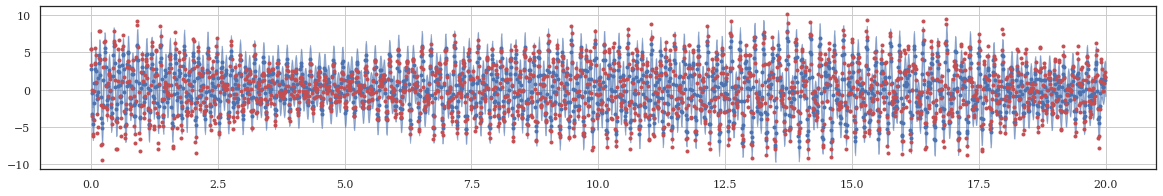

In [30]:
pred_train_mu, pred_train_var = vssgp_model._predict( inputs_new=x_train,use_opt_A=False)


plt.figure(figsize=(20,3))
if x_train.shape[1] == 1:
    plt.plot(x_train.cpu().data.numpy(),pred_train_mu.cpu().data.numpy(),'b.')
    plt.plot(x_train.cpu().data.numpy(),y_train.cpu().data.numpy(),'r.')
    plt.fill_between( x_train.cpu().data.numpy().squeeze(),
                      pred_train_mu.cpu().data.numpy().squeeze() - np.sqrt(pred_train_var.cpu().data.numpy()).squeeze(),
                      pred_train_mu.cpu().data.numpy().squeeze() + np.sqrt(pred_train_var.cpu().data.numpy()).squeeze(),
                      alpha = 0.5, edgecolor = 'b', facecolor = 'b')
else:
    plt.plot(pred_train_mu.cpu().data.numpy(),'b.')
    plt.plot(y_train.cpu().data.numpy(),'r.')
#     plt.fill_between( x_train.cpu().data.numpy().squeeze(),
#                       pred_train_mu.cpu().data.numpy().squeeze() - np.sqrt(pred_train_var.cpu().data.numpy()).squeeze(),
#                       pred_train_mu.cpu().data.numpy().squeeze() + np.sqrt(pred_train_var.cpu().data.numpy()).squeeze(),
#                       alpha = 0.5, edgecolor = 'b', facecolor = 'b')        

In [31]:
#torch.vs
#x_test2 = torch.cat([x_test],dim=0)
#x_test2 = torch.cat([x_test,x_test+5,x_test+10],dim=0)

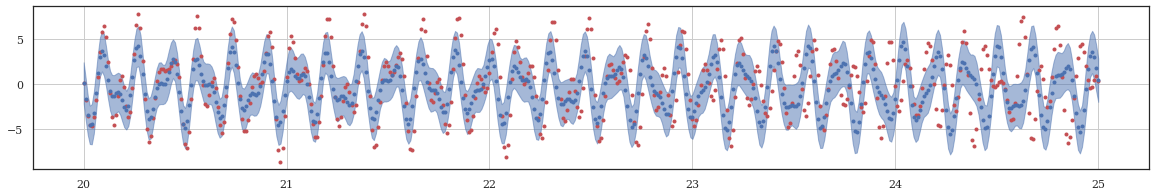

In [32]:
pred_test_mu, pred_test_var = vssgp_model._predict(inputs_new = x_test ,use_opt_A=False)

plt.figure(figsize=(20,3))
if x_test.shape[1] == 1:
    plt.plot(x_test.cpu().data.numpy(),y_test.cpu().data.numpy(),'r.')
    plt.plot(x_test.cpu().data.numpy(),pred_test_mu.cpu().data.numpy(),'b.')
    plt.fill_between( x_test.cpu().data.numpy().squeeze(),
                      pred_test_mu.cpu().data.numpy().squeeze() - np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                      pred_test_mu.cpu().data.numpy().squeeze() + np.sqrt(pred_test_var.cpu().data.numpy()).squeeze(),
                      alpha = 0.5, edgecolor = 'b', facecolor = 'b')
else:   
    plt.plot(pred_test_mu.cpu().data.numpy(),'b.')
    plt.plot(y_test.cpu().data.numpy(),'r.')

In [33]:
E_phi,E_phiT_E_phi, E_cos_sq = vssgp.get_Ephi()
plt.figure(figsize=(10,10))
#plt.imshow(E_phiT_E_phi.cpu().data.numpy())
plt.imshow(E_phi.mm(E_phi.t()).cpu().data.numpy())
plt.show()

TypeError: get_Ephi() missing 1 required positional argument: 'self'